In [538]:
import pandas as pd

In [539]:
cases = pd.read_csv("cases_limpio.csv")
covid_data = pd.read_csv("owid-covid-data.csv")
datos_muertes = pd.read_csv("muerte_limpio.csv")

In [540]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.colors as colors
from folium import (plugins, FeatureGroup, Map, Circle, Marker,
                    LayerControl, Popup, CircleMarker, Vega)
from tslearn.clustering import TimeSeriesKMeans

import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


In [541]:
datos_muertes.set_index(["Pais"],drop=True,inplace=True)

In [542]:
paises = ["Italy","Germany","Brazil","United States"]

In [543]:
datos_interes = datos_muertes.loc[paises]

In [544]:
datos_interes

,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,1/31/2020,...,2/26/2021,2/27/2021,2/28/2021,3/1/2021,3/2/2021,3/3/2021,3/4/2021,3/5/2021,3/6/2021,3/7/2021
Pais,,,,,,,,,,,,,,,,,,,,,
Italy,0,0,0,0,0,0,0,0,0,0,...,97227,97507,97699,97945,98288,98635,98974,99271,99578,99785
Germany,0,0,0,0,0,0,0,0,0,0,...,69939,70092,70152,70514,70926,71285,71554,71852,71951,71984
Brazil,0,0,0,0,0,0,0,0,0,0,...,252835,254221,254942,255720,257361,259271,260970,262770,264325,265411
United States,0,0,0,0,0,0,0,0,0,0,...,510764,512252,513291,514810,516737,519205,521119,522877,524362,525031


## Seleccionamos paises que consideramos relevantes del dataset para analizar 

In [545]:
datos_muertes.columns = pd.to_datetime(datos_muertes.columns)

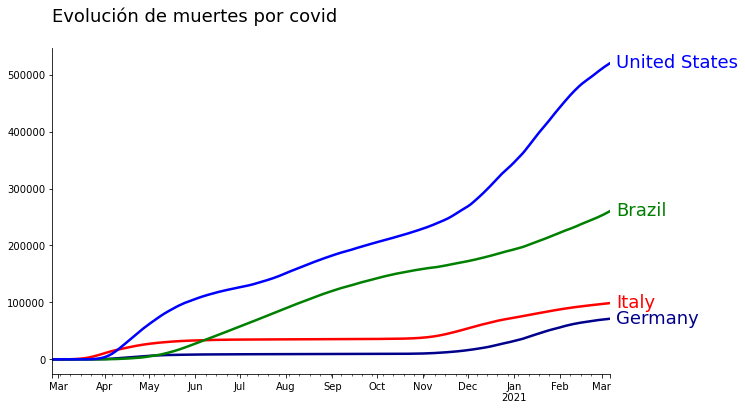

In [546]:
pd.options.plotting.matplotlib.register_converters = True 
delay_days = 35
colors = ['red', 'darkblue', 'green','blue']
fig, ax2 = plt.subplots()
for country, col in zip(paises, colors):
    datos_muertes.loc[country][delay_days:].rolling(7).mean().fillna(
        0).plot(kind='line',
                linewidth=2.5,
                label=country,
                figsize=(10, 6),
                color=col, ax=ax2)
ax2.set_title('Evolución de muertes por covid\n', fontsize=18, loc='left')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
for line, name, sett in zip(ax2.lines, paises, [0.07, 0, 0.0,0.0,0.0]):
    y = line.get_ydata()[-1]
    ax2.annotate(name,
                 xy=(1, y + sett),
                 xytext=(6, 0),
                 color=line.get_color(),
                 xycoords=ax2.get_yaxis_transform(),
                 textcoords="offset points",
                 size=18,
                 va="center")

In [547]:
datos_muertes[last_day]

Pais
Afghanistan    2449
Albania        1939
Algeria        3013
Andorra         112
Angola          514
               ... 
Venezuela      1384
Vietnam          35
Yemen           651
Zambia         1124
Zimbabwe       1485
Name: 2021-03-07 00:00:00, Length: 208, dtype: int64

In [548]:
covid_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hun

In [549]:
covid_data = pd.read_csv("muertes_mill.csv",sep=";")

In [550]:
covid_data.set_index("Pais",inplace=True,drop=True)

In [551]:
covid_data.columns = pd.to_datetime(covid_data.columns)

In [552]:
#location = covid_data.location.unique()
#location

In [553]:
#covid_data = covid_data.set_index(fechas)

In [554]:
#covid_data.drop(columns=["date"],inplace=True)

## Viendo que las curvas para determinados paises evolucionaban de distintas formas decidimos intentar clusterizar los distintos tipos de curva

COVID-19 deaths vs time curves
54512863744.725 --> 34639714504.580 --> 34446738560.545 --> 34299317829.572 --> 34299317829.572 --> 
green cluster, N = 10
red cluster, N = 2
blue cluster, N = 161


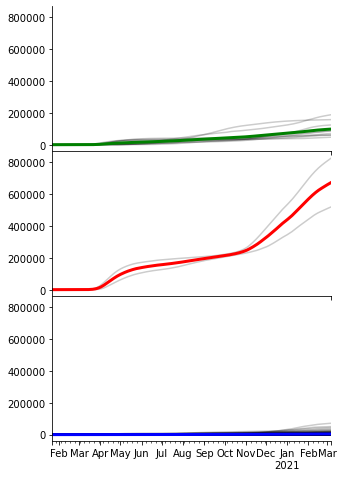

In [555]:
from tslearn.utils import to_time_series_dataset
cluster = 3
df = covid_data.iloc[35:,:]
X_train = df.rolling(7, axis=1, min_periods=1).mean().fillna(0)
colors = ['blue', 'red', 'green']
names = ['blue cluster','red cluster','green cluster']
seed = 1
np.random.seed(seed)
X_train = to_time_series_dataset(X_train.copy())

print('COVID-19 deaths vs time curves')
km = TimeSeriesKMeans(n_clusters=cluster, verbose=1, random_state=seed,
                         max_iter=100)

y_pred = km.fit_predict(X_train)
index=df.index
clusters = pd.Series(data=y_pred, index=index)

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True,figsize=(5, 8))

for yi,cl,xs in zip(range(cluster),[2,1,0],[ax1,ax2,ax3]):
    data = df.rolling(7,axis=1, min_periods=1).mean().fillna(0).loc[clusters[clusters == cl].index]
    data.T.plot(legend=False, alpha=.2,color='black', ax=xs)
    data.mean(axis=0).plot(linewidth=3., color=colors[cl], ax=xs)
    n = len(data)
    print('{}, N = {}'.format(names[cl], n))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['right'].set_visible(False)
f.subplots_adjust(hspace=0)
plt.ylim()
#-0.02, 3.5
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [556]:
clusters

Pais
Central African Republic    0
Chad                        0
Chile                       0
China                       0
Colombia                    2
                           ..
Venezuela                   0
Vietnam                     0
Yemen                       0
Zambia                      0
Zimbabwe                    0
Length: 173, dtype: int64

In [557]:
coord = pd.read_csv("coord.csv",delimiter=",")

In [558]:
coord
# La idea era usar este dataset con coordenadas de cada pais representar cada cluster en un mapa para intentar sacar conclusiones geograficas de la evolucion de las curvas

,Unnamed: 0,lat,long,json
0,US,39.783730,-100.445882,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
1,India,22.351115,78.667743,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
2,Brazil,-10.333333,-53.200000,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
3,Russia,64.686314,97.745306,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
4,Peru,-6.869970,-75.045851,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
...,...,...,...,...
178,Timor-Leste,-8.515198,125.837576,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
179,Grenada,12.136037,-61.690405,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
180,Dominica,19.097403,-70.302803,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
181,Laos,20.017111,103.378253,"{\n ""axes"": [\n {\n ""scale"": ""x"",\n ..."
